<a href="https://colab.research.google.com/github/Termote/Deep_learning_for_optical_imaging/blob/main/Final_project_DefeatChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Data

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Activation
from keras.layers import Conv2D, MaxPooling2D,TimeDistributed, Concatenate, Conv3D, MaxPooling3D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import cv2
import os
import gdown

In [12]:
# Download the data training folder
url = "https://drive.google.com/drive/folders/1M2xGjlMKTfD0cRlI6eS2nEeKe0KKsfMb"
gdown.download_folder(url, quiet=True, use_cookies=False)



['/content/Training Data/common_time.npy',
 '/content/Training Data/ground_truth.npy',
 '/content/Training Data/labels.npy',
 '/content/Training Data/meteo_data.csv',
 '/content/Training Data/X1.npy',
 '/content/Training Data/X2.npy']

In [41]:
import pandas as pd
import os

# File paths and corresponding column names
file_columns = [('/content/Training Data/common_time.npy', 'common_time'),
                ('/content/Training Data/ground_truth.npy', 'ground_truth'),
                ('/content/Training Data/labels.npy', 'labels'),
                ('/content/Training Data/meteo_data.csv', 'meteo_data')]
# Create an empty DataFrame
combined_df = pd.DataFrame()

# Load and add data to the DataFrame
for file_path, column_name in file_columns:
    if file_path.endswith('.npy'):
        data = np.load(file_path, allow_pickle=True)
        df = pd.DataFrame(data, columns=[column_name])
        combined_df = pd.concat([combined_df, df], axis=1)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        df.columns = [f"{column_name}_{col}" for col in df.columns]
        combined_df = pd.concat([combined_df, df], axis=1)

# Display the combined DataFrame
print("Combined DataFrame:")

#remove one of the date columns
combined_df = combined_df.drop('meteo_data_time', axis=1)
combined_df.head(5)

Combined DataFrame:


,common_time,ground_truth,labels,meteo_data_Air_temp,meteo_data_Wind_speed,meteo_data_Wind_dir
0,2021-12-06 08:50:00,21.0,132.0,1.6,1.0,324
1,2021-12-06 09:10:00,34.0,126.0,1.8,1.2,331
2,2021-12-06 09:20:00,52.0,136.0,1.7,1.7,329
3,2021-12-06 09:30:00,70.0,143.0,1.8,1.3,325
4,2021-12-06 09:50:00,82.0,134.0,1.9,1.0,326


In [14]:
# Load images
x1 = np.load('/content/Training Data/X1.npy')
x2 = np.load('/content/Training Data/X2.npy')


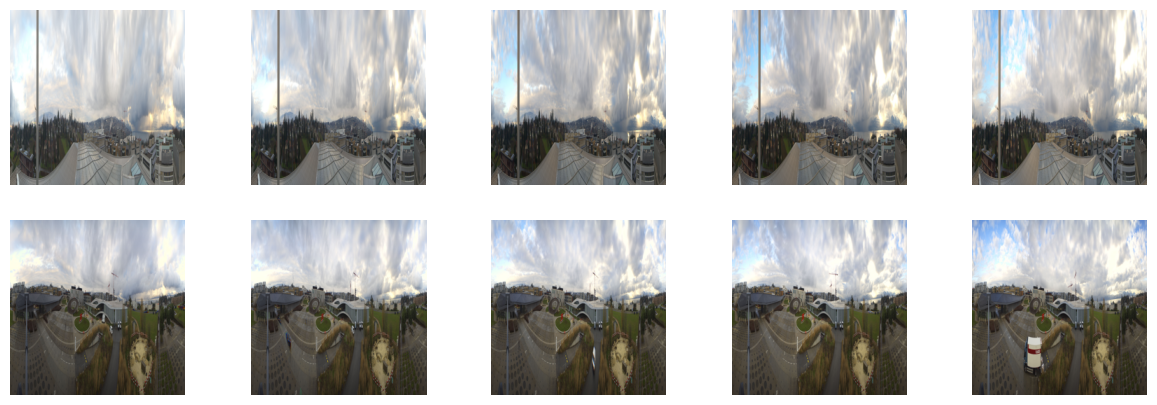

x1 shape:  (10000, 250, 250, 3)
x2 shape:  (10000, 250, 250, 3)


In [15]:
# Create a subplot with two rows and five columns
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# Display images in the subplot
for i in range(5):
    axes[0, i].imshow(x1[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(x2[i])
    axes[1, i].axis('off')

plt.show()

print("x1 shape: ", x1.shape)
print("x2 shape: ", x2.shape)

In [24]:
# Resizing the images to new dimensions

new_dim = (64, 64)

x1_resized = np.array([cv2.resize(img, new_dim) for img in x1])
x2_resized = np.array([cv2.resize(img, new_dim) for img in x2])

# normalize the images

x1_resized = x1_resized / 255.0
x2_resized = x2_resized / 255.0

# del x1
# del x2

x1_resized shape:  (10000, 64, 64, 3)
x2_resized shape:  (10000, 64, 64, 3)


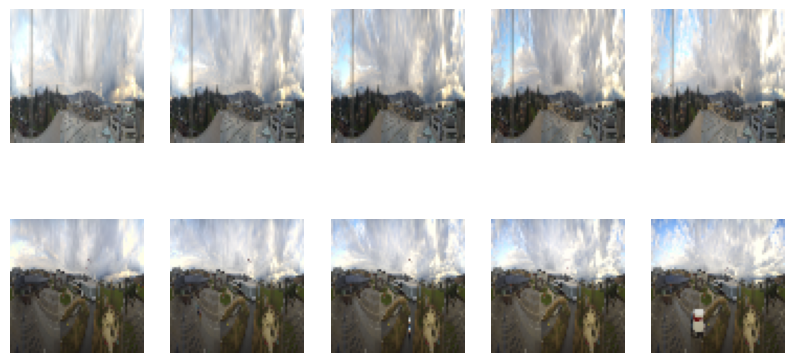

In [17]:
print("x1_resized shape: ", x1_resized.shape)
print("x2_resized shape: ", x2_resized.shape)

# Create a subplot with two rows and five columns
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Display images in the subplot
for i in range(5):
    axes[0, i].imshow(x1_resized[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(x2_resized[i])
    axes[1, i].axis('off')

plt.show()

In [19]:
# #Split data - Conventional way

def split_train_test(data, train_test_ratio):
    train_size = int(len(data) * train_test_ratio)
    return data[:train_size], data[train_size:]

def create_train_test(data_1, data_2, info_ds, train_test_ratio):

    wind_speed = info_ds['meteo_data_Wind_speed']
    wind_speed = np.array(wind_speed)

    labels = info_ds['labels']
    labels = np.array(labels)

    train_x1, test_x1 = split_train_test(data_1, train_test_ratio)
    train_x2, test_x2 = split_train_test(data_2, train_test_ratio)
    train_wind, test_wind = split_train_test(wind_speed, train_test_ratio)

    y_train, y_test = split_train_test(labels, train_test_ratio)

    X_images_train = np.stack((train_x1, train_x2), 1)
    X_images_test = np.stack((test_x1, test_x2), 1)

#Shuffle the data for training
    idx = np.random.permutation(len(X_images_train))

    X_images_train, X_wind_train, y_train = X_images_train[idx], train_wind[idx], y_train[idx]

    return X_images_train, X_wind_train, X_images_test, test_wind, y_train, y_test
    return train_x1, train_x2, train_wind, test_x1, test_x2, test_wind, y_train, y_test

# Split data set
train_test_ratio = 0.2

X_images_train, X_wind_train, X_images_test, X_test_wind, y_train, y_test = create_train_test(x1_resized, x2_resized, combined_df, train_test_ratio)


#train_x1, train_x2, train_wind, test_x1, test_x2, test_wind, y_train, y_test = create_train_test(x1, x2, combined_df, train_test_ratio)



# print("X_images_train shape:", train_x1.shape)
# print("X_images_train shape:", train_x2.shape)

# print("X_wind_train shape:", train_wind.shape)
# print("X_images_test shape:", test_x1.shape)
# print("X_images_test shape:", test_x2.shape)

# print("X_test_wind shape:", test_wind.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

print("X_images_train shape:", X_images_train.shape)
print("X_wind_train shape:", X_wind_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("X_test_wind shape:", X_test_wind.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

#del x1
#del x2

X_images_train shape: (2000, 2, 64, 64, 3)
X_wind_train shape: (2000,)
X_images_test shape: (8000, 2, 64, 64, 3)
X_test_wind shape: (8000,)
y_train shape: (2000,)
y_test shape: (8000,)


#ChatGPT model


#Testing different data set result


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, Flatten, concatenate
import numpy as np

Train with Camera 1 and 2 together

In [26]:
channels = 3
batch_size = 32
new_dim = (64, 64)

input = tf.keras.layers.Input(shape=(new_dim[0], new_dim[1], channels))
input_sequence1 = tf.keras.layers.Input(shape=(2,new_dim [0], new_dim [1], channels)) 

# CNN Block 1
first_input = tf.keras.layers.TimeDistributed(Conv2D(8, kernel_size=3, activation='relu'))(input_sequence1)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)
first_input = tf.keras.layers.TimeDistributed(Conv2D(8, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)

# CNN Block 2
first_input = tf.keras.layers.TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)
first_input = tf.keras.layers.TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)

# Flattening and Reshaping for LSTM
flt = tf.keras.layers.TimeDistributed(Flatten())(first_input)
flt = tf.keras.layers.Reshape((1, -1))(flt)

# LSTM
lstm1 = tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)(flt)

# Output
dense1 = tf.keras.layers.Dense(1, activation='relu')(lstm1)

# Setting input and ouput of model
model = tf.keras.models.Model(inputs=[input_sequence1], outputs=dense1)

model.compile(optimizer="Adam", loss='mse')


# train_generator = DataGenerator(train_x1, train_x2, y_train, batch_size)
# test_generator = DataGenerator(test_x1, test_x2, y_test, batch_size)

# Train the model
# history = model.fit(train_generator, epochs=10, validation_data=test_generator, verbose = 1)

#Remember X_train should be something like (samples, number of images per sample, image width, image height, channels) so (9000,2,250,250,3)
history = model.fit(X_images_train, y_train, shuffle=True, epochs=100, batch_size=32, verbose = 2)

Epoch 1/100
63/63 - 4s - loss: 28901.8828 - 4s/epoch - 61ms/step
Epoch 2/100
63/63 - 0s - loss: 20938.1016 - 450ms/epoch - 7ms/step
Epoch 3/100
63/63 - 0s - loss: 20591.4121 - 451ms/epoch - 7ms/step
Epoch 4/100
63/63 - 0s - loss: 20008.7578 - 440ms/epoch - 7ms/step
Epoch 5/100
63/63 - 0s - loss: 19066.3770 - 441ms/epoch - 7ms/step
Epoch 6/100
63/63 - 1s - loss: 17390.1094 - 532ms/epoch - 8ms/step
Epoch 7/100
63/63 - 1s - loss: 14141.8320 - 509ms/epoch - 8ms/step
Epoch 8/100
63/63 - 1s - loss: 10880.3213 - 626ms/epoch - 10ms/step
Epoch 9/100
63/63 - 0s - loss: 9614.7451 - 485ms/epoch - 8ms/step
Epoch 10/100
63/63 - 0s - loss: 8919.4893 - 447ms/epoch - 7ms/step
Epoch 11/100
63/63 - 0s - loss: 8537.4668 - 459ms/epoch - 7ms/step
Epoch 12/100
63/63 - 1s - loss: 8206.4990 - 511ms/epoch - 8ms/step
Epoch 13/100
63/63 - 1s - loss: 7979.1958 - 576ms/epoch - 9ms/step
Epoch 14/100
63/63 - 0s - loss: 7847.2524 - 451ms/epoch - 7ms/step
Epoch 15/100
63/63 - 0s - loss: 7729.1299 - 446ms/epoch - 7ms/st

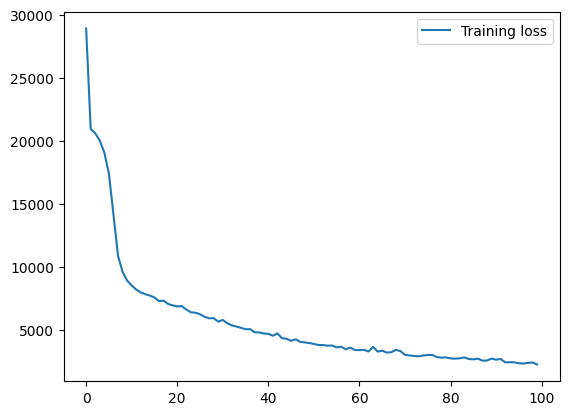

In [28]:
# Plot the training and validation loss

plt.plot(history.history['loss'], label='Training loss')
plt.legend()
plt.show()

In [32]:
# Evaluate the model

from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_images_test)
print(y_pred.shape)
print(y_test.shape)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse)


250/250 [==============================] - 1s 3ms/step
(8000, 1)
(8000,)
RMSE: 236.08134521748477


#Train by Camera 1

#New Data Generator

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, Flatten, concatenate
import numpy as np

In [58]:
# #Split data - Conventional way

def split_train_test(data, train_test_ratio):
    train_size = int(len(data) * train_test_ratio)
    return data[:train_size], data[train_size:]

def create_train_test(data_1, data_2, info_ds, train_test_ratio):

    wind_speed = info_ds['meteo_data_Wind_speed']
    wind_speed = np.array(wind_speed)

    labels = info_ds['labels']
    labels = np.array(labels)

    train_x1, test_x1 = split_train_test(data_1, train_test_ratio)
    train_x2, test_x2 = split_train_test(data_2, train_test_ratio)
    train_wind, test_wind = split_train_test(wind_speed, train_test_ratio)

    y_train, y_test = split_train_test(labels, train_test_ratio)

    return train_x1, train_x2, train_wind, test_x1, test_x2, test_wind, y_train, y_test

# Split data set
train_test_ratio = 0.2


train_x1, train_x2, train_wind, test_x1, test_x2, test_wind, y_train, y_test = create_train_test(batch_x1_resized, batch_x2_resized, combined_df, train_test_ratio)



print("x1 train shape:", train_x1.shape)
print("x2 train shape:", train_x2.shape)

print("X_wind_train shape:", train_wind.shape)
print("x1 test shape:", test_x1.shape)
print("x2 test shape:", test_x2.shape)

print("X_test_wind shape:", test_wind.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



#del x1
#del x2

x1 train shape: (2000, 64, 64, 3)
x2 train shape: (2000, 64, 64, 3)
X_wind_train shape: (2000,)
x1 test shape: (8000, 64, 64, 3)
x2 test shape: (8000, 64, 64, 3)
X_test_wind shape: (8000,)
y_train shape: (2000,)
y_test shape: (8000,)


In [65]:
channels = 3
batch_size = 32
new_dim = (64, 64)

input = tf.keras.layers.Input(shape=(new_dim[0], new_dim[1], channels))
input_sequence1 = tf.keras.layers.Input(shape=(2,new_dim [0], new_dim [1], channels)) 

# CNN Block 1
first_input = tf.keras.layers.TimeDistributed(Conv2D(8, kernel_size=3, activation='relu'))(input_sequence1)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)
first_input = tf.keras.layers.TimeDistributed(Conv2D(8, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)

# CNN Block 2
first_input = tf.keras.layers.TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)
first_input = tf.keras.layers.TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)

# Flattening and Reshaping for LSTM
flt = tf.keras.layers.TimeDistributed(Flatten())(first_input)
flt = tf.keras.layers.Reshape((1, -1))(flt)

# LSTM
lstm1 = tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)(flt)

# Output
dense1 = tf.keras.layers.Dense(1, activation='relu')(lstm1)

# Setting input and ouput of model
model = tf.keras.models.Model(inputs=[input_sequence1], outputs=dense1)

model.compile(optimizer="Adam", loss='mse')

print(train_x1.shape)
print(y_train.shape)
 
# Train the model
history = model.fit(train_x1, y_train, shuffle=True, epochs=100, batch_size=32, verbose = 1)



(2000, 64, 64, 3)
(2000,)
Epoch 1/100


ValueError: ignored

#Adding Wind Data

In [ ]:
# print the first 2 images with labels and corresponding wind speed

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

# Display images in the subplot
for i in range(4):

    axes[0, i].imshow(train_x1[i][0])
    axes[0, i].axis('off')
    # plot title as label and wind speed
    axes[0, i].set_title("Label: {} \nWind speed: {}".format(y_train[i], train_x1[i]))

for i in range(4):
    axes[1, i].imshow(train_x2[i][1])
    axes[1, i].axis('off')
    axes[1, i].set_title("Label: {} \nWind speed: {}".format(y_train[i], train_x2[i]))

plt.show()



In [ ]:
# Create a model
input_shape = (new_dim, new_dim, 3)
input1 = Input(shape=input_shape, name='image1_input')
input2 = Input(shape=input_shape, name='image2_input')
meteo_input = Input(shape=(wind_speed.shape[1],), name='meteo_input')

x1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Flatten()(x1)

x2 = Conv2D(16, (3, 3), activation='relu', padding='same')(input2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(16, (3, 3), activation='relu', padding='same')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Flatten()(x2)

meteo_dense = Dense(32, activation='relu')(meteo_input)

x = concatenate([x1, x2, meteo_dense])
x = tf.keras.layers.Reshape((-1, 1))(x)
x = tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)(x)

output = Dense(1, activation='relu')(x)

model = tf.keras.Model(inputs=[input1, input2, meteo_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')